# Kraken2 Colab Example

This examples shows how to use kraken2 on google colab. Since the default kraken database exceedes colabs resources (46GB DB vs. 12GB RAM), we use a small database with only viral genomes instead.

## Installation with conda

We install kraken2 with [miniconda](https://docs.conda.io/en/latest/miniconda.html)

In [ ]:
%%bash
wget -qnc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
chmod +x ./Miniconda3-latest-Linux-x86_64.sh
./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
conda config --add channels bioconda
conda config --add channels conda-forge
conda install -y kraken2 > /dev/null 2> /dev/null

PREFIX=/usr/local
Unpacking payload ...
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - _openmp_mutex==4.5=1_gnu
    - brotlipy==0.7.0=py39h27cfd23_1003
    - ca-certificates==2021.7.5=h06a4308_1
    - certifi==2021.5.30=py39h06a4308_0
    - cffi==1.14.6=py39h400218f_0
    - chardet==4.0.0=py39h06a4308_1003
    - conda-package-handling==1.7.3=py39h27cfd23_1
    - conda==4.10.3=py39h06a4308_0
    - cryptography==3.4.7=py39hd23ed53_0
    - idna==2.10=pyhd3eb1b0_0
    - ld_impl_linux-64==2.35.1=h7274673_9
    - libffi==3.3=he6710b0_2
    - libgcc-ng==9.3.0=h5101ec6_17
    - libgomp==9.3.0=h5101ec6_17
    - libstdcxx-ng==9.3.0=hd4cf53a_17
    - ncurses==6.2=he6710b0_1
    - openssl==1.1.1k=h27cfd23_0
    - pip==21.1.3=py39h06a4308_0
    - pycosat==0.6.3=py39h27cfd23_0
    - pycparser==2.20=py_2
    - pyopenssl==20.0.1=pyhd3eb1b0_1
    - pysocks==1.7.1=py39h06a4308_0
    - python==3

## Download and build a viral database 

Download the NCBI taxonomy 

In [ ]:
!kraken2-build --download-taxonomy --db viral_db --skip-maps

Untarring taxonomy tree data... done.


Download the viral genome databae. This will take a few minutes

In [ ]:
!kraken2-build --download-library viral --db viral_db

Step 1/2: Performing rsync file transfer of requested files
Rsync file transfer complete.
Step 2/2: Assigning taxonomic IDs to sequences
Processed 11583 projects (14458 sequences, 454.53 Mbp)... done.
All files processed, cleaning up extra sequence files... done, library complete.
Masking low-complexity regions of downloaded library... done.


Combine both into a kraken2 database

In [ ]:
!kraken2-build --build --db viral_db --threads $(grep -c ^processor /proc/cpuinfo)

Creating sequence ID to taxonomy ID map (step 1)...
Sequence ID to taxonomy ID map complete. [0.042s]
Estimating required capacity (step 2)...
Estimated hash table requirement: 527566260 bytes
Capacity estimation complete. [12.601s]
Building database files (step 3)...
Taxonomy parsed and converted.
CHT created with 15 bits reserved for taxid.
Completed processing of 14455 sequences, 454509897 bp
Writing data to disk...  complete.
Database files completed. 21.857s]
Database construction complete. [Total: 2m34.540s]


Let's check how big our database actually is

In [ ]:
!ls -lh viral_db

total 506M
-rw-r--r-- 1 root root 504M Sep 15 05:05 hash.k2d
drwxr-xr-x 3 root root 4.0K Sep 15 04:58 library
-rw-r--r-- 1 root root   64 Sep 15 05:05 opts.k2d
-rw-r--r-- 1 root root 566K Sep 15 05:02 seqid2taxid.map
-rw-r--r-- 1 root root 1.5M Sep 15 05:03 taxo.k2d
drwxr-xr-x 2 root root 4.0K Sep 15 05:02 taxonomy


## Simulate reads

The kraken2 repository comes with some sample viruse genomes and a read simulator

In [ ]:
!if [ ! -d kraken2 ]; then git clone -q https://github.com/DerrickWood/kraken2; fi

We simulate a few paired-end reads from the genomes of sample viruses. We use a high error rate to make the problem difficult given the small viral database

In [ ]:
%%bash
for i in kraken2/data/*.fa; do
  echo "$(basename ${i%.*})"
  perl kraken2/data/simulator.pl --num-frags 1000 --error_rate 0.05 --output-format "$(basename ${i%.*})#.fq" < $i;
done
rm -f reads_1.fq reads_2.fq
cat *_1.fq > reads_1.fq
cat *_2.fq > reads_2.fq

COVID_19
FluA_H1N1
FluA_H2N2
FluA_H3N2
FluB
HIV_1
HIV_2
Lambda
MERS
SARS


## Release the kraken

In [ ]:
!kraken2 --db viral_db --paired reads_1.fq reads_2.fq --output - --report report.txt

Loading database information... done.
10000 sequences (2.00 Mbp) processed in 0.332s (1809.3 Kseq/m, 361.86 Mbp/m).
  9810 sequences classified (98.10%)
  190 sequences unclassified (1.90%)


In [ ]:
!cat report.txt

  1.90	190	190	U	0	unclassified
 98.10	9810	0	R	1	root
 98.10	9810	1	D	10239	  Viruses
 88.34	8834	0	D1	2559587	    Riboviria
 68.83	6883	0	K	2732396	      Orthornavirae
 39.35	3935	0	P	2497569	        Negarnaviricota
 39.35	3935	0	P1	2497571	          Polyploviricotina
 39.35	3935	0	C	2497577	            Insthoviricetes
 39.35	3935	0	O	2499411	              Articulavirales
 39.35	3935	0	F	11308	                Orthomyxoviridae
 29.56	2956	0	G	197911	                  Alphainfluenzavirus
 29.56	2956	19	S	11320	                    Influenza A virus
  9.88	988	0	S1	114727	                      H1N1 subtype
  9.84	984	984	S2	211044	                        Influenza A virus (A/Puerto Rico/8/1934(H1N1))
  0.04	4	4	S2	641809	                        Influenza A virus (A/California/07/2009(H1N1))
  9.76	976	0	S1	119210	                      H3N2 subtype
  9.76	976	976	S2	335341	                        Influenza A virus (A/New York/392/2004(H3N2))
  9.70	970	0	S1	114729	                      H2

It would be nice two make a plot out of these tree, but the two well documented tools are both browser based, i.e. they don't run in colab. The following is a screenshot from krakentools after running `python KrakenTools/kreport2krona.py -r report.txt -o krona_report.txt` and `ktImportText krona_report.txt`

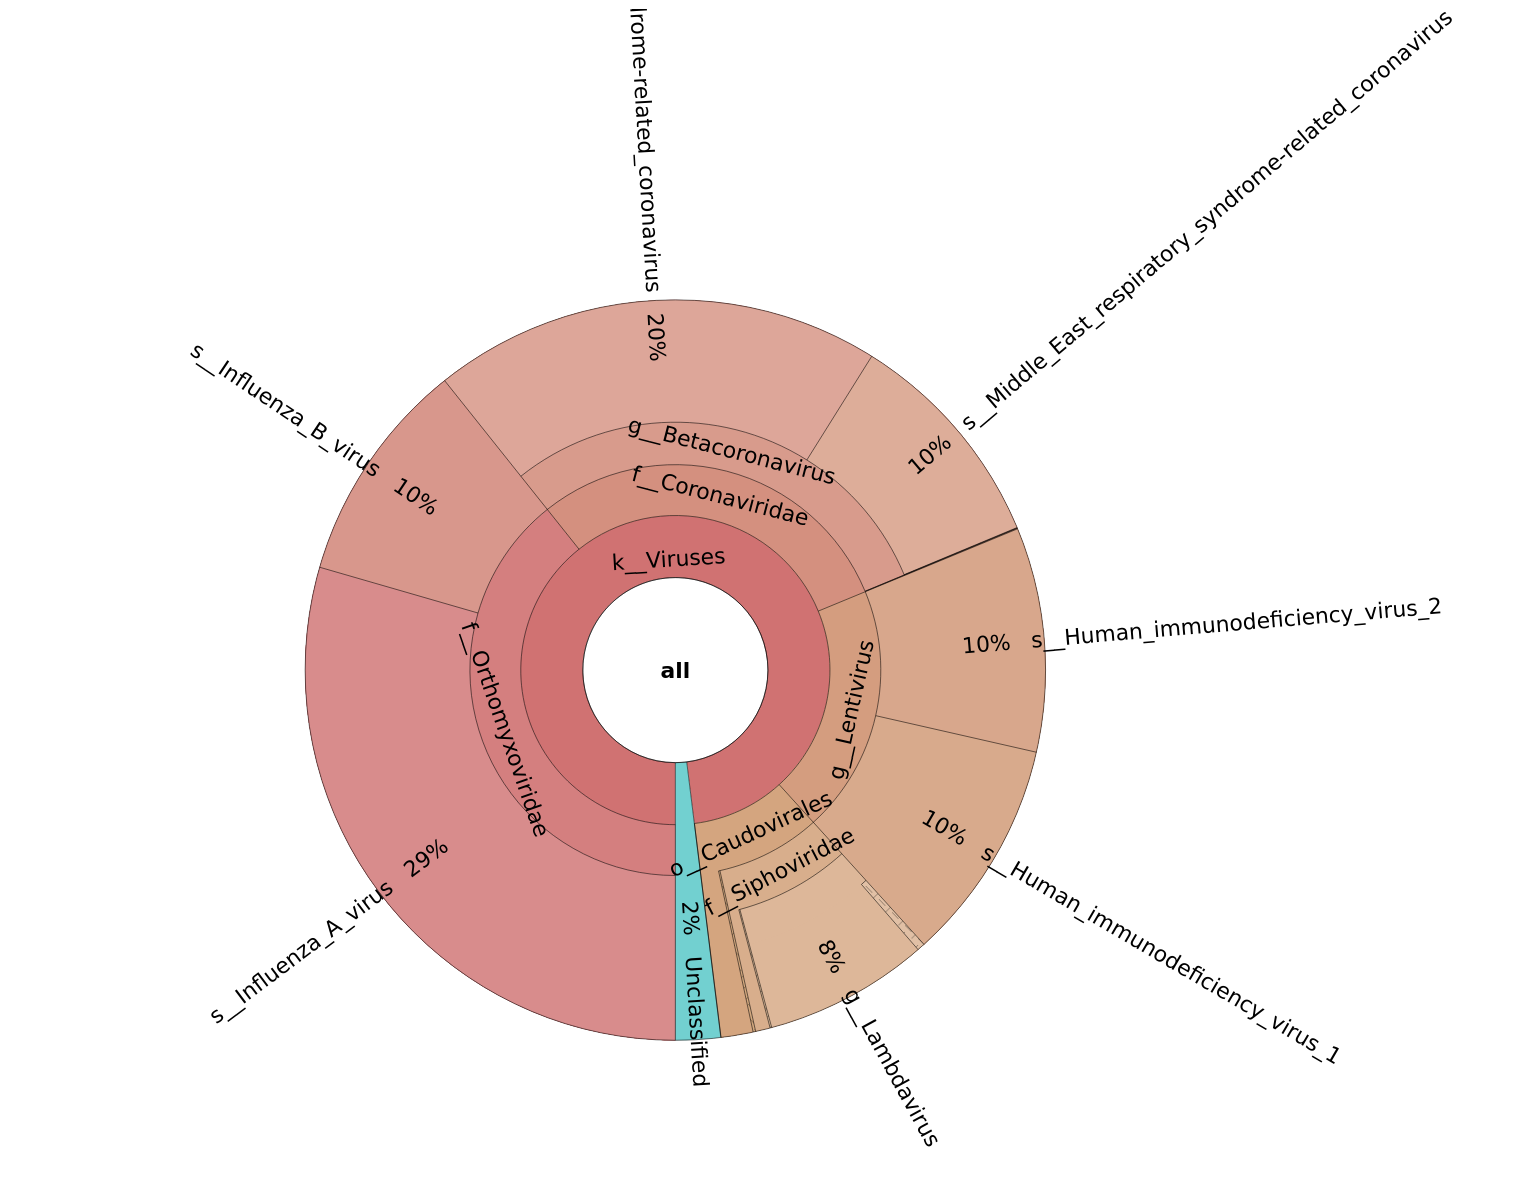